In [22]:
using Gadfly
using Compose
using Colors
base03=parse(Colorant,"#002b36");
base02=parse(Colorant,"#073642");
base01=parse(Colorant,"#586e75");
base00=parse(Colorant,"#657b83");
base0=parse(Colorant,"#839496");
base1=parse(Colorant,"#839496");
base2=parse(Colorant,"#eee8d5");
base3=parse(Colorant,"#fdf6e3");

yellow=parse(Colorant,"#b58900");
orange=parse(Colorant,"#cb4b16");
red=parse(Colorant,"#dc322f");
magenta=parse(Colorant,"#d33682");
violet=parse(Colorant,"#6c71c4");
blue=parse(Colorant,"#268bd2");
cyan=parse(Colorant,"#3aa198");
green=parse(Colorant,"#859900");

In [2]:
function MakeHexagon(Nx::Int)
      Npara=Nx^2;
      N=Npara*3;

      unit=transpose([cos(pi/6),sin(pi/6)])
      a=transpose([2*cos(π/6),0]);
      b=[cos(π/6),1+sin(π/6)];
      bM=transpose(repeat(b,outer=[1,Nx]))
      rotmat=[[cos(2*π/3) -sin(2*π/3)]
            [sin(2*π/3) cos(2*π/3)]]


      Xb=Array{Float64}(N,2);
      Xw=Array{Float64}(N,2);

      ## Creating the positions in the first parallelogram
      for i in 1:Nx
        Xb[i,:]=(i-1)*a;
        Xw[i,:]=unit+(i-1)*a;
      end

      for j in 2:Nx
        Xb[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xb[1:Nx,:]+(j-1)*bM;
        Xw[(Nx*(j-1)+1):(Nx*(j-1)+Nx),:]=Xw[1:Nx,:]+(j-1)*bM;
      end

      subt=Xb[Npara,2]+1
      Xb[1:Npara,1]=Xb[1:Npara,1]-(Nx-1)*b[1];
      Xw[1:Npara,1]=Xw[1:Npara,1]-(Nx-1)*b[1];
      Xb[1:Npara,2]=Xb[1:Npara,2]-subt;
      Xw[1:Npara,2]=Xw[1:Npara,2]-subt;

      Xb[Npara+(1:Npara),1]=rotmat[1,1]*Xb[1:Npara,1]+rotmat[1,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),1]=rotmat[1,1]*Xw[1:Npara,1]+rotmat[1,2]*Xw[1:Npara,2];
      Xb[Npara+(1:Npara),2]=rotmat[2,1]*Xb[1:Npara,1]+rotmat[2,2]*Xb[1:Npara,2];
      Xw[Npara+(1:Npara),2]=rotmat[2,1]*Xw[1:Npara,1]+rotmat[2,2]*Xw[1:Npara,2];

      Xb[2*Npara+(1:Npara),1]=rotmat[1,1]*Xb[Npara+(1:Npara),1]+rotmat[1,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),1]=rotmat[1,1]*Xw[Npara+(1:Npara),1]+rotmat[1,2]*Xw[Npara+(1:Npara),2];
      Xb[2*Npara+(1:Npara),2]=rotmat[2,1]*Xb[Npara+(1:Npara),1]+rotmat[2,2]*Xb[Npara+(1:Npara),2];
      Xw[2*Npara+(1:Npara),2]=rotmat[2,1]*Xw[Npara+(1:Npara),1]+rotmat[2,2]*Xw[Npara+(1:Npara),2];

      vb=sortperm(Xb[:,1]+Npara*Xb[:,2])
      vw=sortperm(Xw[:,1]+Npara*Xw[:,2])
      Xb=Xb[vb,:];
      Xw=Xw[vw,:];

  return Xb, Xw
end


MakeHexagon (generic function with 1 method)

In [3]:
function MakeBonds(Nx::Int,Xb::Array{Float64,2},Xw::Array{Float64,2})
  Npara=Nx^2;
  N=Npara*3;

  nrowb=[collect(Nx:(2*Nx));collect((2*Nx-1):-1:(Nx+1))]
  nroww=flipdim(nrowb,1)

  i0b=ones(nrowb)
  i0w=ones(nroww)
  for i in 2:length(nrowb)
      i0b[i]=i0b[i-1]+nrowb[i-1]
      i0w[i]=i0w[i-1]+nroww[i-1]
  end
  push!(i0b,N+1);
  push!(i0w,N+1);

  offsetb=zeros(N+1)
  offsetw=zeros(N+1)
  for i in 1:Nx
      offsetb[i0b[i]:i0b[i+1]]=i-1
      offsetb[i0b[i+Nx]:i0b[i+1+Nx]]=Nx-i
      offsetw[i0w[i]:i0w[i+1]]=i-1
      offsetw[i0w[i+Nx]:i0w[i+1+Nx]]=Nx-i
  end

  Bondsw=Array{Int64}(N,3);
  Bondsb=Array{Int64}(N,3);
  for i in 1:N
      Bondsb[i,2]=i+offsetb[i];
      Bondsw[i,2]=i-offsetw[i];
      Bondsb[i,1]=i+1+offsetb[i];
      Bondsw[i,1]=i-1-offsetw[i];
      Bondsb[i,3]=i-Nx;
      Bondsw[i,3]=i+Nx;
  end

  boundaryb=ones(Int64,N,3);
  boundaryw=ones(Int64,N,3);
  i=1
  while isapprox(Xb[1,2],Xb[i,2])
      Bondsb[i,3]=N-Nx+i
      boundaryb[i,3]=0
      Bondsw[N-Nx+i,3]=i
      boundaryw[N-Nx+i,3]=0
      #println(N-Nx+i,' ',i)
      i+=1
  end

  Bondsw[i0w[1:Nx],1]=i0b[Nx+1+(1:Nx)]-1;
  boundaryw[i0w[1:Nx],1]=0
  Bondsb[i0b[Nx+1+(1:Nx)]-1,1]=i0w[1:Nx];
  boundaryb[i0b[Nx+1+(1:Nx)]-1,1]=0

  Bondsw[i0w[1+(1:Nx)]-1,2]=i0b[Nx+(1:Nx)];
  boundaryw[i0w[1+(1:Nx)]-1,2]=0
  Bondsb[i0b[Nx+(1:Nx)],2]=i0w[1+(1:Nx)]-1;
  boundaryb[i0b[Nx+(1:Nx)],2]=0

  return Bondsb, Bondsw, boundaryb, boundaryw
end


MakeBonds (generic function with 1 method)

In [4]:
function U(x::Float64,y::Float64)
    return [2x*y, x^2-y^2]
end

U (generic function with 1 method)

In [5]:
function delta(i::Int,j::Int)
    Ri=transpose(Xw[i,:])[:,1];
    nei=Bondsw[i,j];
    
    Rj=transpose(Xb[nei,:])[:,1];
    Ui=U(Xw[i,1],Xw[i,2]);
    
    Uj=U(Xb[nei,1],Xb[nei,2]);
    
    return Ri+Ui-Rj-Uj;
end

delta (generic function with 1 method)

In [6]:
function Jij(i::Int,j::Int,β::Real)
    return 1-β*(norm(delta(i,j))-1)
end

Jij (generic function with 1 method)

In [7]:
Nx=10;
N=3*Nx^2;
Xb,Xw=MakeHexagon(Nx);
Bondsb, Bondsw, bb, bw= MakeBonds(Nx,Xb,Xw);

In [8]:
Xbn=copy(Xb);
Xwn=copy(Xw);
C=.01
for i in 1:N
    Xbn[i,1]+=C*2*Xb[i,1]*Xb[i,2]
    Xbn[i,2]+=C*(Xb[i,1]^2-Xb[i,2]^2)
    
    Xwn[i,1]+=C*2*Xw[i,1]*Xw[i,2]
    Xwn[i,2]+=C*(Xw[i,1]^2-Xw[i,2]^2)
end

In [164]:
Jstrain=zeros(Float64,N,3);
for i in 1:N
    for j in 1:3
        Jstrain[i,j]=Jij(i,j,.001)
    end
end
nJstrain=(Jstrain-.96)/(.05);

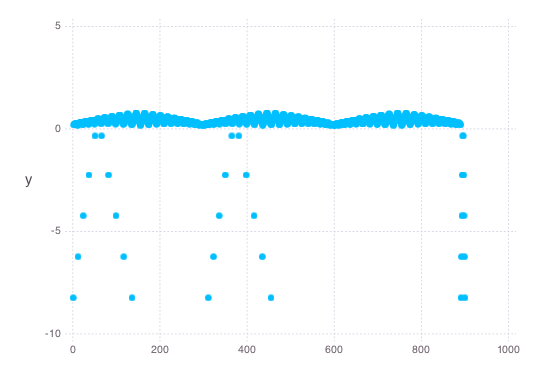

In [165]:
plot(y=nJstrain,Theme(highlight_width=0pt))

In [122]:
minx=minimum([Xb[:,1];Xw[:,1];Xbn[:,1];Xwn[:,1]])-.15;
miny=minimum([Xb[:,2];Xw[:,2];Xbn[:,2];Xwn[:,2]])-.15;
maxx=maximum([Xb[:,1];Xw[:,1];Xbn[:,1];Xwn[:,1]])+.15;
maxy=maximum([Xb[:,2];Xw[:,2];Xbn[:,2];Xwn[:,2]])+.15;

function sc(X::Array)
    Xn=zeros(X)
    Xn[:,1]=(X[:,1]-minx)/(maxx-minx)
    Xn[:,2]=(X[:,2]-miny)/(maxy-miny)
    return Xn
end

Xbs=sc(Xb)
Xbns=sc(Xbn)
Xws=sc(Xw)
Xwns=sc(Xwn);

In [120]:
mvb=zeros(Float64,N)
mvw=zeros(Float64,N)
for i in 1:N
    mvb[i]=norm(Xbn[i,:]-Xb[i,:])
    mvw[i]=norm(Xwn[i,:]-Xw[i,:])
end

maxmv=maximum([mvb;mvw])
minmv=minimum([mvb;mvw])

mvbs=(mvb-minmv)/(maxmv-minmv)
mvws=(mvw-minmv)/(maxmv-minmv);

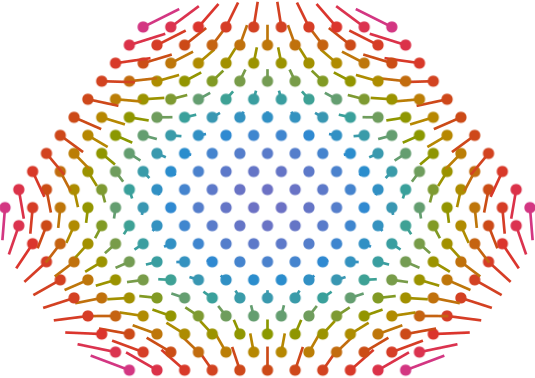

In [127]:
ctx=context()
for i in 1:N
    compose!(ctx,compose(context(),
    line([  (Xbs[i,1],Xbs[i,2]) , (Xbns[i,1],Xbns[i,2])   ])
    ,circle(Xbs[i,1],Xbs[i,2],.008)
    ,stroke(f(mvbs[i])), fill(f(mvbs[i])), linewidth(2pt)
    ) )
end
compose!(ctx)
#img=SVG("distorted.svg",6inch,6inch)
#draw(img,compose!(ctx,circle(Xbs[:,1],Xbs[:,2],.008*ones(Xb[:,1])) ))

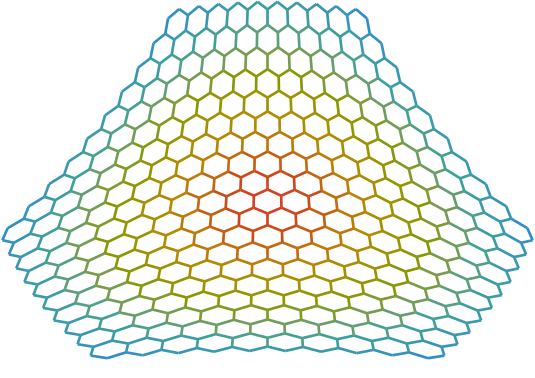

In [167]:
ctx2=context()
for i in 1:N
    for j in 1:3
        compose!(ctx2,compose(context(),
        line([  (Xwns[i,1]*bw[i,j],Xwns[i,2]*bw[i,j]),(Xbns[Bondsw[i,j],1]*bw[i,j],Xbns[Bondsw[i,j],2]*bw[i,j]) ]),
        stroke(f(nJstrain[i,j]*bw[i,j])),fill(base03),linewidth(2pt)
        ))
    end
end
compose!(ctx2)

In [58]:
import Colors.weighted_color_mean 
function weighted_color_mean{S <: Number,T}(
        cs::AbstractArray{Lab{T},1}, ws::AbstractArray{S,1})
    l = 0.0
    a = 0.0
    b = 0.0
    sumws = sum(ws)
    for (c, w) in zip(cs, ws)
        w /= sumws
        l += w * c.l
        a += w * c.a
        b += w * c.b
    end
    Lab(l, a, b)
end

function lab_gradient(cs::Color...)
    if length(cs) < 2
        error("Two or more colors are needed for gradients")
    end

    cs_lab = [convert(Lab, c) for c in cs]
    n = length(cs_lab)
    function f(p::Float64)
        @assert 0.0 <= p <= 1.0
        i = 1 + min(n - 2, max(0, floor(Int, p*(n-1))))
        w = p*(n-1) + 1 - i
        weighted_color_mean([cs_lab[i], cs_lab[i+1]], [1.0 - w, w])
    end
    f
end

lab_gradient (generic function with 1 method)

In [107]:
f=lab_gradient(violet,blue,cyan,green,yellow,orange,red,magenta)

f (generic function with 1 method)

In [108]:
x=collect(0.:.01:1.)
y=Array(ColorTypes.Lab{Float64},length(x))
for i in 1:length(x)
    y[i]=f(x[i])
end
y